**Dealing with Missing Values**

One of the first steps in building a good predictive model is to carefully handle missing values at the start. 
There's quite a lot of missing data in this dataset, so in this kernel I've illustrated various ways that we can impute missing values by carefully using the data we already have and I've outlined some key assumptions and rationale made in filling these missing values.

I think some of these approaches are better than filling in missing values with the medians for the fields (for example) or letting models deal with them in their default manner (xgboost for instance will have all the missing values as another category)

After investigating the data in some detail there also appears to be some fields which represent similar if not the same information which I think we can probably be remove as they are redundant. 

There are also potentially some inconsistent fields and potentially incorrect data that I discovered on the way and outlined this in this notebook

The approaches use to deal with missing values also have to be made to the test data consistently - but I've not illustrated here in the interest of the kernel speed.

Ideally after each step taken to deal with missing values you would probably want to carry out some cross-validation to see if it has helped improve your model - I haven't done this here but it would be interested to know if any of the adjustments do help improve the score so please comment if they do!

As always if you found the kernel useful please upvote :) 

In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import neighbors
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

In [100]:
import os
os.getcwd()
os.chdir('/home/ghk829/zillow_data')

In [ ]:
#Start of by reading in the data and merging the datasets
prop = pd.read_csv('./properties_2016.csv')
train = pd.read_csv("./train_2016_v2.csv")

for c, dtype in zip(prop.columns, prop.dtypes):	
    if dtype == np.float64:		
        prop[c] = prop[c].astype(np.float32)

df_train = train.merge(prop, how='left', on='parcelid')
del prop, train
df_train = df_train.drop(['parcelid', 'transactiondate'], axis=1)


In [ ]:
#Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in df_train.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=df_train[numcols].corr())
plt.show()
plt.gcf().clear()

Let's start by removing some 'potentially' redundant variables

The following are all very strongly correlated as can be seen by the dark red path in the heatmap:
'calculatedfinishedsquarefeet'
'finishedsquarefeet12'
'finishedsquarefeet13'
'finishedsquarefeet15'
'finishedsquarefeet6'

By looking at the claims description they represent very similair pieces of information (the area of the property) lets pick the one with the fewest number of missing values and drop the rest. Let's plot the missing values first.

In [ ]:
missing_df = df_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()



Let's start off by potentially removing some 'redundant' variables and then some others ones which are 'easy' to fix

In [ ]:
#'calculatedfinishedsquarefeet' has the fewest missing values so lets remove the others, note also that except for 'finishedsquarefeet12' the rest have large amount of missing values anyways. 
#Also if you look at my script in https://www.kaggle.com/nikunjm88/creating-additional-features 'calculatedfinishedsquarefeet' appears to be the most important variable
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions, lets remove finishedsquarefeet50 as it has more missing values
dropcols.append('finishedsquarefeet50')

#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')


In [20]:
#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = df_train.hashottuborspa.isnull()
df_train.loc[index,'hashottuborspa'] = "None"

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field - these two fields should have the same information I assume?
print(df_train.hashottuborspa.value_counts())
print(df_train.pooltypeid10.value_counts())

#lets remove 'pooltypeid10' as has more missing values
dropcols.append('pooltypeid10')

#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = df_train.pooltypeid2.isnull()
df_train.loc[index,'pooltypeid2'] = 0

index = df_train.pooltypeid7.isnull()
df_train.loc[index,'pooltypeid7'] = 0

index = df_train.poolcnt.isnull()
df_train.loc[index,'poolcnt'] = 0



None    87910
True     2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64


In [21]:
#Theres more missing values in the 'poolsizesum' then in 'poolcnt', Let's fill in median values for poolsizesum where pool count is >0 and missing. I think this is sensible assumption as residential pool sizes are fairly standard size I guess in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable (https://www.kaggle.com/nikunjm88/creating-additional-features) so imputing with the median hopefully won't cause too much of an issue
print(df_train.poolsizesum.isnull().sum())
print(df_train.poolcnt.value_counts())

#Fill in those properties that have a pool with median pool value
poolsizesum_median = df_train.loc[df_train['poolcnt'] > 0, 'poolsizesum'].median()
df_train.loc[(df_train['poolcnt'] > 0) & (df_train['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
df_train.loc[(df_train['poolcnt'] == 0), 'poolsizesum'] = 0



89306
0.0    72374
1.0    17901
Name: poolcnt, dtype: int64


In [22]:
#There seems to be inconsistency between the fireplaceflag and fireplace cnt - my guess is that these should be the same
print(df_train.fireplaceflag.isnull().sum())
print(df_train.fireplacecnt.isnull().sum())

#There seems to be 80668 properties without fireplace according to the 'fireplacecnt' but the 'fireplace flag' says they are 90053 missing values
#Lets instead create the fireplaceflag from scratch using 'fireplacecnt' as there are less missing values here
df_train['fireplaceflag']= "No"
df_train.loc[df_train['fireplacecnt']>0,'fireplaceflag']= "Yes"

index = df_train.fireplacecnt.isnull()
df_train.loc[index,'fireplacecnt'] = 0

#Tax deliquency flag - assume if it is null then doesn't exist
index = df_train.taxdelinquencyflag.isnull()
df_train.loc[index,'taxdelinquencyflag'] = "None"



90053
80668


In [23]:
#Same number of missing values between garage count and garage size - assume this is because when there are properties with no garages then both variables are NA
print(df_train.garagecarcnt.isnull().sum())
print(df_train.garagetotalsqft.isnull().sum())

#Assume if Null in garage count it means there are no garages
index = df_train.garagecarcnt.isnull()
df_train.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = df_train.garagetotalsqft.isnull()
df_train.loc[index,'garagetotalsqft'] = 0

#Let's fill in some missing values using the most common value for those variables where this might be a sensible approach
#AC Type - Mostly 1's, which corresponds to central AC. Reasonable to assume most other properties are similar.
df_train['airconditioningtypeid'].value_counts()
index = df_train.airconditioningtypeid.isnull()
df_train.loc[index,'airconditioningtypeid'] = 1



60338
60338


In [24]:
#heating or system - Mostly 2, which corresponds to central heating so seems reasonable to assume most other properties have central heating  
print(df_train['heatingorsystemtypeid'].value_counts())
index = df_train.heatingorsystemtypeid.isnull()
df_train.loc[index,'heatingorsystemtypeid'] = 2


2.0     38303
7.0     15519
24.0     1071
6.0       970
20.0       97
13.0       76
18.0       25
1.0        13
14.0        2
10.0        2
11.0        1
12.0        1
Name: heatingorsystemtypeid, dtype: int64


In [25]:
# 'threequarterbathnbr' - not an important variable according to https://www.kaggle.com/nikunjm88/creating-additional-features, so fill with most common value
print(df_train['threequarterbathnbr'].value_counts())
index = df_train.threequarterbathnbr.isnull()
df_train.loc[index,'threequarterbathnbr'] = 1


1.0    11912
2.0       90
3.0        6
4.0        1
Name: threequarterbathnbr, dtype: int64


There's still fields with alot of data missing. Let's remove fields that have 97% missing values. 97% is quite subjective, but if you look at https://www.kaggle.com/nikunjm88/creating-additional-features, the variables with more than 97% missing values do not appear to be that important anyways


In [26]:
missingvalues_prop = (df_train.isnull().sum()/len(df_train)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.97].field.tolist()
dropcols = dropcols + missingvaluescols
df_train = df_train.drop(dropcols, axis=1)


                           field  proportion
6            buildingclasstypeid    0.999823
13          finishedsquarefeet13    0.999634
3                   basementsqft    0.999524
41                   storytypeid    0.999524
46            yardbuildingsqft26    0.998948
2       architecturalstyletypeid    0.997109
43        typeconstructiontypeid    0.996688
16           finishedsquarefeet6    0.995336
9                     decktypeid    0.992711
29                  pooltypeid10    0.987139
56            taxdelinquencyyear    0.980249
45            yardbuildingsqft17    0.970690
14          finishedsquarefeet15    0.960521
10      finishedfloor1squarefeet    0.924054
15          finishedsquarefeet50    0.924054
48               numberofstories    0.772141
38          regionidneighborhood    0.601086
7          buildingqualitytypeid    0.364564
34            propertyzoningdesc    0.354052
44                       unitcnt    0.353608
26             lotsizesquarefeet    0.112434
12        

There's quite a few variables which are probably dependant on longtitude and latitude data
Lets try fill in some of the missing variables using geographically nearby properties (by using the longtitude and latitude information)
I've used the k-nearest neighbours function from https://www.kaggle.com/auroralht/restoring-the-missing-geo-data with some minor amendments


In [27]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'predicting' )
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

#function to deal with variables that are actually string/categories
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc


We use k nearest neighbours to fill in blanks for some of the variables that might be be able to be filled in using geographically nearby properties 
Please note - I've put fraction size as 0.15 so the kernel does not time out. In reality I suspect you probably want to use fraction = 1 (all the data)
You will also probably want to use some sort of cross validation technique to select the appropriate value of k. I've used k=1 so its quick to run.


In [28]:
#buildingqualitytypeid - assume it is the similar to the nearest property. Probably makes senses if its a property in a block of flats, i.e if block was built all at the same time and therefore all flats will have similar quality 
#Use the same logic for propertycountylandusecode (assume it is same as nearest property i.e two properties right next to each other are likely to have the same code) & propertyzoningdesc. 
#These assumptions are only reasonable if you actually have nearby properties to the one with the missing value

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'buildingqualitytypeid', fraction = 0.15, n_neighbors = 1 )


zoningcode2int( df = df_train,
                            target = 'propertycountylandusecode' )
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode', fraction = 0.15, n_neighbors = 1 )

zoningcode2int( df = df_train,
                            target = 'propertyzoningdesc' )

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertyzoningdesc', fraction = 0.15, n_neighbors = 1 )

#regionidcity, regionidneighborhood & regionidzip - assume it is the same as the nereast property. 
#As mentioned above, this is ok if there's a property very nearby to the one with missing values (I leave it up to the reader to check if this is the case!)
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15, n_neighbors = 1 )

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidneighborhood', fraction = 0.15, n_neighbors = 1 )

fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.15, n_neighbors = 1 )

#unitcnt - the number of structures the unit is built into. Assume it is the same as the nearest properties. If the property with missing values is in a block of flats or in a terrace street then this is probably ok - but again I leave it up to the reader to check if this is the case!
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'unitcnt', fraction = 0.15, n_neighbors = 1 )

#yearbuilt - assume it is the same as the nearest property. This assumes properties all near to each other were built around the same time
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'yearbuilt', fraction = 0.15, n_neighbors = 1 )

#lot size square feet - not sure what to do about this one. Lets use nearest neighbours. Assume it has same lot size as property closest to it
fillna_knn( df = df_train,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'lotsizesquarefeet', fraction = 0.15, n_neighbors = 1 )


fitting
('the shape of active features: ', (6,))
predicting
out of threshold: 13.9801282246% > 10%
fit and transform
('num of categories: ', (78,))
recover the nan value
fitting
('the shape of active features: ', (50,))
predicting
writing result to df
('num of unperdictable data: ', 0.0)
fit and transform
('num of categories: ', (1997,))
recover the nan value
fitting
('the shape of active features: ', (1053,))
predicting
writing result to df
('num of unperdictable data: ', 0.0)
fitting
('the shape of active features: ', (168,))
predicting
writing result to df
('num of unperdictable data: ', 2.0)
fitting
('the shape of active features: ', (385,))
predicting
writing result to df
('num of unperdictable data: ', 189.0)
fitting
('the shape of active features: ', (377,))
predicting
writing result to df
('num of unperdictable data: ', 0.0)
fitting
('the shape of active features: ', (4,))
predicting
out of threshold: 14.9113464069% > 10%
fitting
('the shape of active features: ', (124,))
predi

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

**finishedfloor1squarefeet** - this is most correlated with calculatedfinishedsquarefeet according to the heatmap so lets see if we can use calculatedfinishedsquarefeet to fill in some of the finishedfloor1squarefeet


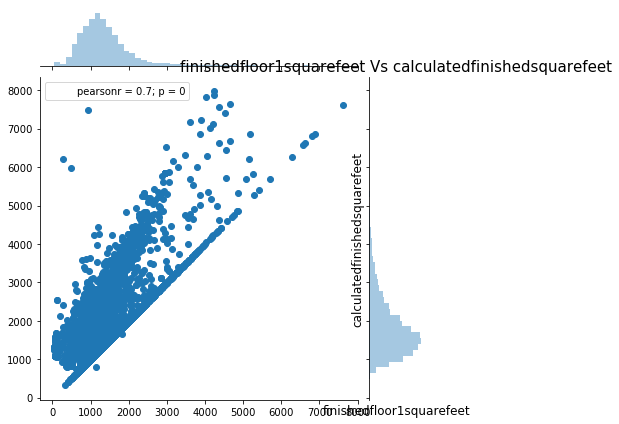

       logerror  airconditioningtypeid  bathroomcnt  bedroomcnt  \
46088    0.0980                    1.0          2.0         3.0   
58830   -0.0377                    1.0          1.0         2.0   

       buildingqualitytypeid  finishedfloor1squarefeet  \
46088                    NaN                    1821.0   
58830                    NaN                    1130.0   

       calculatedfinishedsquarefeet    fips  fireplacecnt  garagecarcnt  \
46088                        1654.0  6111.0           1.0           1.0   
58830                         800.0  6111.0           0.0           2.0   

              ...           yearbuilt numberofstories  fireplaceflag  \
46088         ...              1945.0             1.0            Yes   
58830         ...              1960.0             1.0             No   

       structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
46088                    137697.0           433491.0          2015.0   
58830                     58000.0   

In [29]:
plt.figure(figsize=(12,12))
sns.jointplot(x=df_train.finishedfloor1squarefeet.values, y=df_train.calculatedfinishedsquarefeet.values)
plt.ylabel('calculatedfinishedsquarefeet', fontsize=12)
plt.xlabel('finishedfloor1squarefeet', fontsize=12)
plt.title("finishedfloor1squarefeet Vs calculatedfinishedsquarefeet", fontsize=15)
plt.show()

#There are some properties where finishedfloor1squarefeet and calculatedfinishedsquarefeetare are both exactly the same - probably because its a studio flat of some sort so that the area on the first floor is equivalent to the total area, lets see how many there are
#For now assume if the number of stories is 1 then the finishedfloor1squarefeet is the same as calculatedfinishedsquarefeet
df_train.loc[(df_train['finishedfloor1squarefeet'].isnull()) & (df_train['numberofstories']==1),'finishedfloor1squarefeet'] = df_train.loc[(df_train['finishedfloor1squarefeet'].isnull()) & (df_train['numberofstories']==1),'calculatedfinishedsquarefeet']

#I also discovered that there seems to be two properties that have finishedfloor1squarefeet greater than calculated finishedsquarefeet. Notice also that they have big logerrors aswell - my guess is that the Zillow House price model found it difficult to predict these points due to the fact that they probably had potentially 'incorrect' data input values?
#Discussion point - should we be removing these points or leave them in as they are or 'fix' them? I think it really depends on whether the test data has similar points which may be wrong as we'll want to predict big log errors for these incorrect points aswell I guess...
#For now just remove them.
print(df_train.loc[df_train['calculatedfinishedsquarefeet']<df_train['finishedfloor1squarefeet']])
droprows = df_train.loc[df_train['calculatedfinishedsquarefeet']<df_train['finishedfloor1squarefeet']].index
df_train = df_train.drop(droprows)



In [30]:
#Let's check whats missing still
print(df_train.isnull().sum())


logerror                            0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           32909
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           0
lotsizesquarefeet                   0
poolcnt                             0
poolsizesum                         0
pooltypeid2                         0
pooltypeid7                         0
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc                  0
rawcensustractandblock              0
regionidcity                        0
regionidcounty                      0
regionidneig

Let's look at filling in some of the tax related variables

structuretaxvaluedollarcnt      1.000000
taxvaluedollarcnt               0.826052
taxamount                       0.795013
calculatedfinishedsquarefeet    0.716487
landtaxvaluedollarcnt           0.623292
bathroomcnt                     0.586639
finishedfloor1squarefeet        0.560661
bedroomcnt                      0.305401
yearbuilt                       0.297487
numberofstories                 0.222932
poolsizesum                     0.212777
poolcnt                         0.210389
pooltypeid2                     0.205170
threequarterbathnbr             0.196258
garagetotalsqft                 0.182972
pooltypeid7                     0.155389
garagecarcnt                    0.126714
fireplacecnt                    0.075147
censustractandblock             0.038538
rawcensustractandblock          0.038140
fips                            0.038011
logerror                        0.022084
lotsizesquarefeet               0.013136
regionidneighborhood            0.010707
propertylanduset

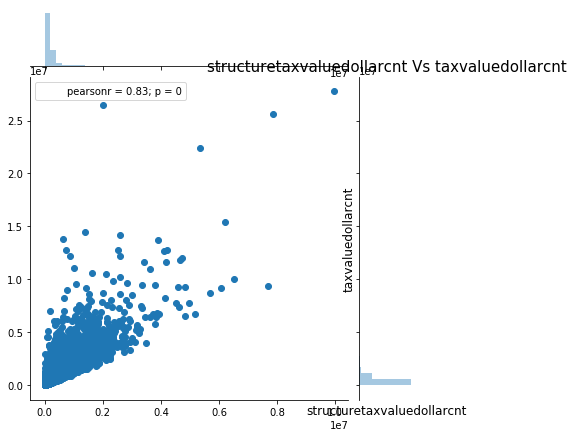

count    3.800000e+02
mean     2.918108e+05
std      5.095444e+05
min      2.200000e+01
25%      3.760475e+04
50%      1.256650e+05
75%      2.529950e+05
max      4.477220e+06
Name: taxvaluedollarcnt, dtype: float64
count    9.027300e+04
mean     4.576706e+05
std      5.548889e+05
min      2.200000e+01
25%      1.990020e+05
50%      3.428720e+05
75%      5.405890e+05
max      2.775000e+07
Name: taxvaluedollarcnt, dtype: float64
logerror                            0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           32909
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           

In [31]:
#taxvaluedollarcnt & landtaxvaluedollarcnt - set it equal to the tax amount (most correlated value). Single story property so assume they are all the same
df_train.loc[df_train.taxvaluedollarcnt.isnull(),'taxvaluedollarcnt'] = df_train.loc[df_train.taxvaluedollarcnt.isnull(),'taxamount']
df_train.loc[df_train.landtaxvaluedollarcnt.isnull(),'landtaxvaluedollarcnt'] = df_train.loc[df_train.landtaxvaluedollarcnt.isnull(),'taxamount']

#structure tax value dollar - fill this in using its most correlated variable
x =  df_train.corr()
print(x.structuretaxvaluedollarcnt.sort_values(ascending = False))

#taxvaluedollarcnt is most correlated variable, let's see how they are related 
plt.figure(figsize=(12,12))
sns.jointplot(x=df_train.structuretaxvaluedollarcnt.values, y=df_train.taxvaluedollarcnt.values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('structuretaxvaluedollarcnt', fontsize=12)
plt.title("structuretaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

#Lets look at the distribution of taxvaluedollar cnt where structuretaxvaluedollarcnt is missing just to make sure we are predicting missing values in the body of the taxvaluedollarcnt distribution
print(df_train.loc[df_train['structuretaxvaluedollarcnt'].isnull(),'taxvaluedollarcnt'].describe())
print(df_train['taxvaluedollarcnt'].describe())

#Slightly amend the k nearest neighbour function so it works on regression
def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    X_train = df[cols]
    scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train[base].values.reshape(-1, 1))
    rescaledX = scaler.transform(X_train[base].values.reshape(-1, 1))

    X_train = rescaledX[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    # fitting the model
    knn.fit(X_train, Y_train)
    # predict the response
    X_test = rescaledX[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[df_train[target].isnull(),target] = pred
    return

#fill in structuretaxvaluedollarcnt using taxvaluedollarcnt as per the above
fillna_knn_reg(df = df_train, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt')

#Do the same thing for tax amount, as taxvaluedollarcnt is its most correlated variable
fillna_knn_reg(df = df_train, base = ['taxvaluedollarcnt'], target = 'taxamount')
print(df_train.isnull().sum())

In [32]:
#Let's see whats left
df_train.isnull().sum()


logerror                            0
airconditioningtypeid               0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           32909
finishedfloor1squarefeet        74971
calculatedfinishedsquarefeet      661
fips                                0
fireplacecnt                        0
garagecarcnt                        0
garagetotalsqft                     0
hashottuborspa                      0
heatingorsystemtypeid               0
latitude                            0
longitude                           0
lotsizesquarefeet                   0
poolcnt                             0
poolsizesum                         0
pooltypeid2                         0
pooltypeid7                         0
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc                  0
rawcensustractandblock              0
regionidcity                        0
regionidcounty                      0
regionidneig

**calculatedfinishedsquarefeet **- this is one of the most important variables (https://www.kaggle.com/nikunjm88/creating-additional-features). Some suggestions on how to fill it in:

Use K nearest neighbours regressor using the number of bathroom and bedrooms (as more bathrooms and bedrooms means bigger the area) and structuretaxvaluedollarcnt (as  I'm assuming the size of the property has an impact on the tax). 
Could alternatively fit a regression model on calculated finished square feet, given its so important, such as using lasso regression for instance.

So there's a couple of missing values left - I'm not going to go through all of them but I hope the above provides some ideas on how you can sensibly fill in missing values, instead of using default approaches of filling them in using the median values etc

Some additional points/caveats:
- The K nearest neighbours function might not always be able to find a nearest value and by default it will categorise it into a seperate category. 
- The K value for nearest neighbours may not be optimal - I suggest it might be a good idea to use cross-validation to find the best k value. Also don't forgot to change fraction to 1 when you run this script (I have left it as 0.15 to prevent the kernel timing out)
- As mentioned above, it would be reasonable to check that properties with missing values being predicted using knn are close to properties with missing values. Ie make sure your not predicting missing values using properties extremely far away in different cities/neighbourhoods etc
- The adjustments above also have to be made to the test data, so potentially combined the train and test data and make the same adjustments
- Prior to fitting models, categorical variables need to be one-hot encoded (there are some categorical features encoded as numbers and some tree-based methods may by default assume they are ordinal!). Probably a good idea to transform some of the skewed features aswell.

Just a thought - I think we need to be very careful how we treat outliers that exist in test set. We are trying to predict errors in Zillows model. Potentially bigger errors are most likely to exist if there are outliers/errors in the data - for example, in the notebook above we spotted 2 claims where the area of the first floor is bigger than the area of the total property - probably a data error and these  two properties have errors which are larger than the average (Zillows model probably found it hard to predict them due to them being outliers/erros in data entry). But we want to be able predict these big errors and correcting these outliers I don't think will help. Likewise properties with missing values may be more difficult to predict by the Zillow model and therefore have big errors  - so filling in the missing values won't neccesarily help (which contradicts the purpose of this notebook! :) )

Its probably worthwhile doing doing cross-validation work after making each change to understand if the changes help 

Interested to hear if any of the adjustments outlined in the notebook helps improve your score, so please comment if they do! 

Please upvote if you found this notebook useful aswell :)


In [33]:
import pandas as pd

In [ ]:
catcols+=['longitude','latitude','assessmentyear']

In [34]:
def pd_change_category_by_names(data_frame,names):
    for i,col_name in enumerate(data_frame.dtypes.index):
        if col_name in names:
            data_frame[col_name] = data_frame[col_name].astype('category')
            print(col_name+" is changed to category")
            print("---------------------------------")
    print(data_frame.dtypes)

In [41]:
pd_change_category_by_names(df_train,catcols)

airconditioningtypeid is changed to category
---------------------------------
buildingqualitytypeid is changed to category
---------------------------------
fips is changed to category
---------------------------------
hashottuborspa is changed to category
---------------------------------
heatingorsystemtypeid is changed to category
---------------------------------
latitude is changed to category
---------------------------------
longitude is changed to category
---------------------------------
pooltypeid2 is changed to category
---------------------------------
pooltypeid7 is changed to category
---------------------------------
propertycountylandusecode is changed to category
---------------------------------
propertylandusetypeid is changed to category
---------------------------------
propertyzoningdesc is changed to category
---------------------------------
rawcensustractandblock is changed to category
---------------------------------
regionidcity is changed to category
----

In [36]:
import math

In [42]:
df_train.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock
0,0.0276,1.0,2.0,3.0,4.0,NaN,1684.0,6037.0,0.0,0.0,...,1959.0,NaN,No,122754.0,360170.0,2015.0,237416.0,6735.879883,None,6.037107e+13
1,-0.1684,1.0,3.5,4.0,NaN,NaN,2263.0,6059.0,0.0,2.0,...,2014.0,NaN,No,346458.0,585529.0,2015.0,239071.0,10153.019531,None,NaN
2,-0.0040,1.0,3.0,2.0,4.0,NaN,2217.0,6037.0,0.0,0.0,...,1940.0,NaN,No,61994.0,119906.0,2015.0,57912.0,11484.480469,None,6.037464e+13
3,0.0218,1.0,2.0,2.0,4.0,NaN,839.0,6037.0,0.0,0.0,...,1987.0,NaN,No,171518.0,244880.0,2015.0,73362.0,3048.739990,None,6.037296e+13
4,-0.0050,1.0,2.5,4.0,NaN,NaN,2283.0,6059.0,0.0,2.0,...,1981.0,2.0,No,169574.0,434551.0,2015.0,264977.0,5488.959961,None,6.059042e+13


In [43]:
category=[]
for i,value in enumerate(df_train.dtypes.index):
    if df_train.dtypes.get(list(df_train.dtypes.index)[i])=='float32':
        if list(df_train.dtypes.index)[i]=='calculatedfinishedsquarefeet':
            continue
        else:
            print(str(i)+":"+value)
            df_train=eval("df_train.assign(new{}=lambda x: x.{} /x.calculatedfinishedsquarefeet)".format(value,value))
    else:
        category.append(i)

2:bathroomcnt
3:bedroomcnt
5:finishedfloor1squarefeet
8:fireplacecnt
9:garagecarcnt
10:garagetotalsqft
15:lotsizesquarefeet
16:poolcnt
17:poolsizesum
28:roomcnt
29:threequarterbathnbr
30:unitcnt
32:numberofstories
34:structuretaxvaluedollarcnt
35:taxvaluedollarcnt
37:landtaxvaluedollarcnt
38:taxamount
40:censustractandblock


In [71]:
names=list(df_train.columns)

In [72]:
names.index('roomcnt')

28

In [73]:
#roomcnt = 28
reference=[28]

In [74]:
new=df_train.ix[:,reference+category+list(range(42,59))]

In [95]:
#Creating Dummy
def f(df):
    if df['roomcnt'] == 0:
        val = 0
    else:
        val = 1
    return val
new['room_yn'] = new.apply(f,axis=1)

/home/ghk829/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
import h2o
import matplotlib.pyplot as plt

In [55]:
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ghk829/miniconda2/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1symUD
  JVM stdout: /tmp/tmp1symUD/h2o_ghk829_started_from_python.out
  JVM stderr: /tmp/tmp1symUD/h2o_ghk829_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,4 months and 3 days !!!
H2O cluster name:,H2O_from_python_ghk829_ayfp6h
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [56]:
df=h2o.H2OFrame(python_obj=new.to_dict("list"))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [57]:
splits = df.split_frame(ratios=[0.7, 0.15])

In [58]:
train = splits[0]
valid = splits[1]
test = splits[2]

In [59]:
y_names= df.col_names[0]
x_names = df.col_names[1:len(df.col_names)-1]

In [60]:
x_names

[u'regionidcity',
 u'regionidzip',
 u'newfinishedfloor1squarefeet',
 u'yearbuilt',
 u'newpoolsizesum',
 u'fireplaceflag',
 u'regionidcounty',
 u'taxdelinquencyflag',
 u'propertyzoningdesc',
 u'newlandtaxvaluedollarcnt',
 u'newfireplacecnt',
 u'newnumberofstories',
 u'newcensustractandblock',
 u'latitude',
 u'newbedroomcnt',
 u'newtaxvaluedollarcnt',
 u'newgaragetotalsqft',
 u'hashottuborspa',
 u'newunitcnt',
 u'newstructuretaxvaluedollarcnt',
 u'buildingqualitytypeid',
 u'newroomcnt',
 u'assessmentyear',
 u'propertylandusetypeid',
 u'propertycountylandusecode',
 u'regionidneighborhood',
 u'fips',
 u'newtaxamount',
 u'heatingorsystemtypeid',
 u'airconditioningtypeid',
 u'newlotsizesquarefeet',
 u'rawcensustractandblock',
 u'pooltypeid2',
 u'longitude',
 u'pooltypeid7',
 u'newthreequarterbathnbr',
 u'newgaragecarcnt']

In [61]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [62]:
fit1 = H2ORandomForestEstimator(model_id = 'fit1')

In [63]:
fit1.train(x=x_names, y=y_names, training_frame=train,validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [64]:
fit1.cross_validation_metrics_summary

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  fit1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.026261036548
RMSE: 0.162052573408
MAE: 0.071778859033
RMSLE: NaN
Mean Residual Deviance: 0.026261036548

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.0259404911029
RMSE: 0.161060520001
MAE: 0.0702132305921
RMSLE: NaN
Mean Residual Deviance: 0.0259404911029
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-09-25 10:15:38,0.044 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-09-25 10:15:40,2.181 sec,1.0,0.2104777,0.0843412,0.0443009,0.1933219,0.0817100,0.0373734
,2017-09-25 10:15:41,3.377 sec,2.0,0.2002835,0.0825734,0.0401135,0.1780396,0.0784196,0.0316981
,2017-09-25 10:15:45,7.447 sec,11.0,0.1721601,0.0762679,0.0296391,0.1629171,0.0721160,0.0265420
,2017-09-25 10:15:49,11.629 sec,23.0,0.1649053,0.0737397,0.0271938,0.1621813,0.0712900,0.0263028
,2017-09-25 10:15:53,15.693 sec,38.0,0.1629617,0.0722918,0.0265565,0.1613931,0.0705104,0.0260477
,2017-09-25 10:15:57,19.559 sec,50.0,0.1620526,0.0717789,0.0262610,0.1610605,0.0702132,0.0259405


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
newstructuretaxvaluedollarcnt,1700.1613769,1.0,0.0719376
newtaxamount,1679.1607666,0.9876479,0.0710490
newbedroomcnt,1538.8630371,0.9051276,0.0651127
yearbuilt,1521.1374512,0.8947018,0.0643627
newtaxvaluedollarcnt,1494.6595459,0.8791280,0.0632423
---,---,---,---
hashottuborspa,45.9931831,0.0270522,0.0019461
fireplaceflag,32.9111443,0.0193577,0.0013925
regionidcounty,26.5354118,0.0156076,0.0011228
pooltypeid2,23.6055069,0.0138843,0.0009988



See the whole table with table.as_data_frame()


<bound method H2ORandomForestEstimator.cross_validation_metrics_summary of >